_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/GRB_ML)._

# Swift Data Pre-processing
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

This notebook summarizes how to pre-process these data in different resolutions. Through this document, we are using the _python3_ implementations from the _scripts_ folder. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software. The following sections reproduce the method used in [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract) to pre-process data.

**REMARK:** As [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract) said: _"It should be noted that the DTFT is not necessarily an optimal preprocessing solution for separating GRBs. Other preprocessing techniques that preserve the information content in the light curve would yield equally valid representations of GRB classes, though possibly not as cleanly separated."_ Take the [Jespersen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...896L..20J/abstract) method seriously, and understand well why they implemented each step. For more information, see section 2.2 of their paper.

First, we need to import the **main.py** file to our notebook (and some packages needed):

In [1]:
from scripts import main
import os  # Import os to handle folders and files
import time  # Import module to check code time executing
import numpy as np  # Import numpy module to read tables, manage data, etc
from prettytable import PrettyTable  # Import module to do tables

Then, create a new object from the `main.py` class and, if you need, set the data, table and results folder paths (by default it will be the "Data", "Table", and "Results" folders inside the path containing this notebook):

In [2]:
%matplotlib inline
object1 = main.SwiftGRBWorker()
object1.original_data_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Data\Original_Data'  # Change data path
object1.table_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Tables'  # Change table path
object1.results_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Results'  # Change results path

Now, we want to process the data to prepare it for tSNE implementation. This process consists of 4 phases, following:
* Limit all GRBs out of $T_{100}$
* Normalize light curves (lc) by total fluence in 15-350keV band
* Pad with zeros all GRBs, putting then in the same time standard basis
* Concatenate data from all bands and perform DFT to get Fourier amplitude spectrum

In the next sections, we are going to describe these processes and show how to use some functions to do these steps.

## Changing the Swift GRB binning
By default, this notebook preprocesses the data for 64ms binning in Swift. There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ and _end_ variables.

Through this package, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $1$ for 1s binning and change the end variable to "sn5_10s" to use data with a signal-to-noise ratio higher than 5 or 10 s binning (these data don't have uniform time spacing).

In [3]:
object1.res = 64  # Resolution for the Light Curve Data in ms, could be 2, 8, 16, 64 (default), 256 and 1 (this last in s)

It is advisable not to change both variables at the same time; this could cause unknown bugs when running package routines and sub-routines. Additionally, you will need the data downloaded for the selected binning.

Last, from the download section, extract the GRB Names filtered by download error:

In [4]:
sum_general_path = os.path.join(object1.table_path, "summary_general.txt")  # Path to summary table
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True, autostrip=True)  # GRB Names total array
GRB_errors = np.genfromtxt(os.path.join(object1.original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]

If you haven't downloaded the data yet, check the _Swift_Data_Download_ notebook.

## Data visualization
As an introduction, we are going to see how the data looks. You can plot the original light curves for any GRB using the `plot_any_grb` function, specifically, using the argument _t_ in False (indicating that you don't need to filter the LC). In this case, it takes the form (of the resolution selected in the past section):

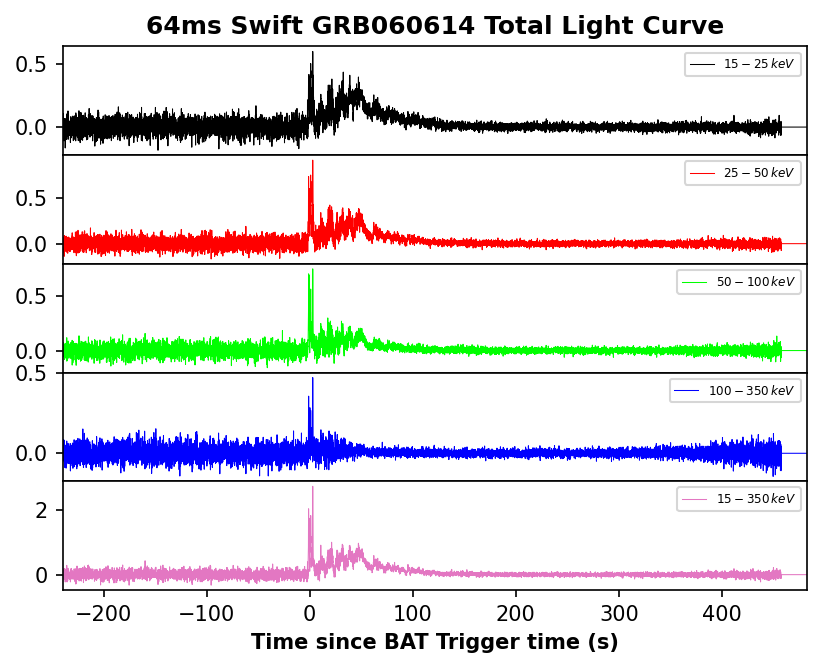

In [5]:
name = 'GRB060614'  # Change this name if you want another GRB
fig = object1.plot_any_grb(name, t=False)

As you can see, there are four bands in keV and the total (sum of all bands) in the 15-350keV plot. The x-axis represents the time since BAT Trigger, and the y-axis represents the GRB counts/sec/det.

In the following sections, we are working with the four bands and their total, but to perform non-linear dimensionality reduction, we don't need to use the total band.

## First step: Limit lc out of $T_{100}$
In this step, we need to extract the durations for all GRBs available in `summary_burst_durations.txt` using the `durations_checker` instance. If you don't have any tables downloaded yet, use the following code block to do it:

In [6]:
object1.summary_tables_download()  # Comment this line if you already have downloaded the tables

If you don't pass any GRB name to the `durations_checker` instance, this function returns a list containing three values for each GRB in the table: Name, $T_{i}$ start and end times (in seconds), where $i$ can be 50, 90, or 100 (default value), but if you pass it a name, then it returns these values only by this GRB.

In [7]:
durations_times = object1.durations_checker(name)
print(f"{durations_times[0, 0]} has T_100={round(float(durations_times[0, 2])-float(durations_times[0, 1]), 3)}s (T_100 start={durations_times[0, 1]}s, T_100 end={durations_times[0, 2]}s)")

GRB060614 has T_100=180.576s (T_100 start=-1.496s, T_100 end=179.080s)


With these values, we can limit our GRB lc using the instance `lc_limiter`.  In this function, it is possible directly set the time limiters in seconds or pass it an integer to indicate what duration we need (however, these integers can be only 50, 90, and 100). So, we try to extract the lc out of $T_{100}$ by using an integer and setting limits manually, then comparing both:

In [8]:
limited_data_1 = object1.lc_limiter(name)  # Limiting by T_100
limited_data_2 = object1.lc_limiter(name, limits=(durations_times[0, 1], durations_times[0, 2]))  # By values
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_2)}")
# Table printing:
x = PrettyTable()
column_names = 'Time (s)', '15-25keV', 'Error', '25-50keV', 'Error', '50-100keV', 'Error', '100-350keV', 'Error','15-350keV', 'Error'
x.clear_rows()  # Clear rows of data
[x.add_column(column_names[i], np.round(limited_data_1[:3, i], 3)) for i in range(len(limited_data_1[0]))]  # Add initial 3 rows to each column
x.add_row(['...']*len(column_names))  # Add dots space
x.add_rows(np.round(limited_data_1[-3:-1], decimals=3))  # Add last 2 rows to each column
print(x)

Are both arrays equal? Answer=True
+----------+----------+-------+----------+-------+-----------+-------+------------+-------+-----------+-------+
| Time (s) | 15-25keV | Error | 25-50keV | Error | 50-100keV | Error | 100-350keV | Error | 15-350keV | Error |
+----------+----------+-------+----------+-------+-----------+-------+------------+-------+-----------+-------+
|  -1.456  |   0.12   | 0.077 |  0.243   |  0.07 |   0.177   | 0.061 |   0.059    | 0.052 |   0.599   | 0.131 |
|  -1.392  |   0.2    | 0.077 |  0.125   | 0.091 |    0.28   |  0.07 |   -0.012   | 0.051 |   0.593   | 0.148 |
|  -1.328  |  0.139   | 0.064 |  0.174   | 0.085 |   0.251   | 0.076 |   0.052    | 0.052 |   0.616   |  0.14 |
|   ...    |   ...    |  ...  |   ...    |  ...  |    ...    |  ...  |    ...     |  ...  |    ...    |  ...  |
| 178.896  |  -0.003  | 0.018 |  0.009   | 0.018 |   0.019   | 0.016 |    0.01    | 0.015 |   0.035   | 0.034 |
|  178.96  |  0.012   | 0.019 |  -0.008  | 0.018 |   -0.027  | 0.015 

Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Note that both methods are equivalent, and the lc values are now between start and end times for $T_{100}$. Graphically, the lc out of $T_{100}$ is:

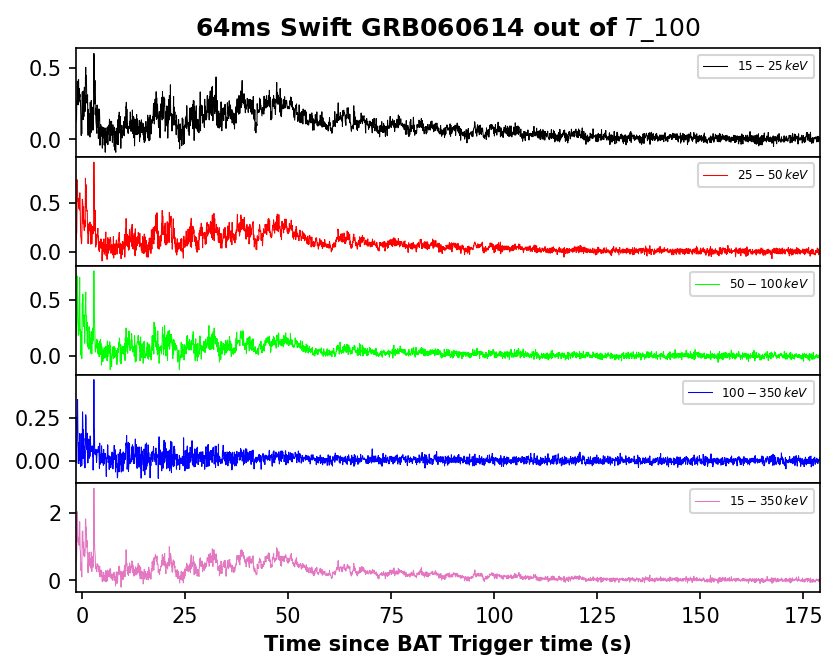

In [9]:
fig_limited, axes_limited = object1.plot_any_grb(name, t=100)  # Plot Light Curve out of T_100

So, the next step is to do this for all downloaded GRBs, to get a much faster performance of execution, we can use the `so_much_lc_limiters` function:

In [10]:
time1 = time.perf_counter()
limited_data, GRB_names, errors = object1.so_much_lc_limiters(GRB_names)
time2 = time.perf_counter()
print(f"{len(limited_data)} GRBs limited in {round(time2-time1, 2)}s ({len(errors)} Errors)")
y = PrettyTable()  # Create printable table
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)

LC Limiting: 100%|██████████| 1369/1369 [06:47<00:00,  3.36GRB/s]


1318 GRBs limited in 411.69s (51 Errors)
+------------+---------+---------+------------+
|    Name    | t_start |  t_end  | Error Type |
+------------+---------+---------+------------+
| GRB200324A |         |         | ValueError |
| GRB190326A |   0.0   |  0.104  |  Length=1  |
| GRB180718A |   0.0   |   0.1   |  Length=1  |
| GRB170906B | -11.776 |  7.424  |  Length=0  |
| GRB170524A |   0.0   |   0.12  |  Length=2  |
| GRB170112A |  -0.004 |  0.056  |  Length=1  |
| GRB161104A |  -0.016 |   0.1   |  Length=1  |
| GRB160601A |  -0.024 |   0.12  |  Length=2  |
| GRB160525A |         |         | ValueError |
| GRB160501A |         |         | ValueError |
| GRB151107A |         |         | ValueError |
| GRB150710B |         |         | ValueError |
| GRB150424A |         |         | IndexError |
| GRB150101B |   0.0   |  0.016  |  Length=1  |
| GRB150101A |   0.0   |  0.068  |  Length=1  |
| GRB141102A |   0.0   |   14.4  | Only zeros |
| GRB140622A |  -0.024 |  0.128  |  Length=2  |

As you see, the function returns a tuple of limited arrays and errors for all GRBs. In this case, 51 GRBs have any of the following errors:
* _FileNotFoundError_ if GRB does not have any data file downloaded in the selected resolution.
* _ValueError_ if the code can't get any limit values.
* _IndexError_ if the GRB does not appear in the `summary_burst_durations` table.
* _Length={value}_ if the limited GRB data has less than three discrete points.
* _Only zeros_ if the limited GRB data only has zeros.

Additionally, the second argument returned by `so_much_lc_limiters` is a GRB names array indicating the order of results (the first argument returned). This order is now our `GRB_names` variable because it does not have the error names.

To check if the `so_much_lc_limiters` instance is doing its job well, we are going to compare (for the GRB selected before) if the data stored in _limited_data_1_ and obtained in parallelizing are equal:

In [11]:
random_index = GRB_names.index(name)  # Search random GRB in new GRB names list
limited_data_random_GRB = np.array(limited_data[random_index])  # Extract limited values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(limited_data_1, limited_data_random_GRB)}")

Are both arrays equal? Answer=True


## Second step: Normalizing Light Curves
GRBs have one fact that is widely known: long GRBs typically but not always has higher fluence. To avoid t-SNE being distracted by this fact, we need to normalize our lc by total time-integrated flux, `lc_normalizer` instance does this job by using the Simpson's Rule in any array. This function returns a tuple normalized data, total time-integrated flux if _print_area_ parameter is _True_, otherwise only returns normalized data:

In [12]:
normalized_data_random_GRB, total_flux = object1.lc_normalizer(limited_data_random_GRB, print_area=True)
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(normalized_data_random_GRB[:2], decimals=4))  # Add new rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(normalized_data_random_GRB[np.r_[-2:0]], decimals=4))  # Add new rows of limited data
print(f"Total time-integrated flux for {name} is: {round(total_flux, 4)}")
print(x)

Total time-integrated flux for GRB060614 is: 38.6704
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
| Time (s) | 15-25keV | Error  | 25-50keV | Error  | 50-100keV | Error  | 100-350keV | Error  | 15-350keV | Error  |
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
|  -1.456  |  0.0031  | 0.002  |  0.0063  | 0.0018 |   0.0046  | 0.0016 |   0.0015   | 0.0013 |   0.0155  | 0.0034 |
|  -1.392  |  0.0052  | 0.002  |  0.0032  | 0.0024 |   0.0072  | 0.0018 |  -0.0003   | 0.0013 |   0.0153  | 0.0038 |
|   ...    |   ...    |  ...   |   ...    |  ...   |    ...    |  ...   |    ...     |  ...   |    ...    |  ...   |
|  178.96  |  0.0003  | 0.0005 | -0.0002  | 0.0005 |  -0.0007  | 0.0004 |   0.0004   | 0.0004 |  -0.0002  | 0.0009 |
| 179.024  | -0.0002  | 0.0005 | -0.0002  | 0.0005 |   0.0002  | 0.0004 |  -0.0001   | 0.0004 |  -0.0002  | 0.0009 |
+----------

Note that normalized data are only limited data divided by 15-350keV integrated flux. So, the next step is to do this for all limited GRBs, to get a much faster performance of execution, we can use the `so_much_normalize` function. To check if this instance is doing its job well, we are going to compare (for the random GRB selected before) if the data stored in _normalized_data_random_GRB_ and obtained in parallelizing are equal:

In [13]:
normalized_data = object1.so_much_normalize(limited_data)  # Normalizing all light curves
normalized_data_random_GRB_2 = normalized_data[random_index]  # Extract normalized values for random GRB
print(f"Are both arrays equal? Answer={np.array_equal(normalized_data_random_GRB, normalized_data_random_GRB_2)}")

LC Normalizing: 100%|██████████| 1318/1318 [00:29<00:00, 44.83GRB/s] 


Are both arrays equal? Answer=True


## Third step: Zero Padding
With all GRBs limited out of $T_{100}$ and normalized, we need now to zero-pad their light curves to place them on the same time basis. The `zero_pad` instance performs this job by checking the max length of a data set and looking for the best suitable array size to do Fast Fourier Transform (FFT, the next step in data pre-processing).

Here, we are going to see how this function zero pad the data at its end for the GRB selected before:

In [14]:
zero_padded_data = object1.so_much_zero_pad(normalized_data)
zero_padded_data_random_GRB = zero_padded_data[random_index]
print(f"Best FFT suitable data length: {len(zero_padded_data_random_GRB)}")
x.clear_rows()  # Clear rows of data
x.add_rows(np.round(zero_padded_data_random_GRB[:2], decimals=4))  # Add new rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(zero_padded_data_random_GRB[len(normalized_data_random_GRB)-2:len(normalized_data_random_GRB)+2], decimals=4))  # Add new end rows of limited data
x.add_row(['...'] * len(column_names))  # Add dots space
x.add_rows(np.round(zero_padded_data_random_GRB[-3:-1], decimals=4))  # Add new end rows of limited data
print(x)

LC Zero-Padding: 100%|██████████| 1318/1318 [00:29<00:00, 44.82GRB/s]


Best FFT suitable data length: 15309
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
| Time (s) | 15-25keV | Error  | 25-50keV | Error  | 50-100keV | Error  | 100-350keV | Error  | 15-350keV | Error  |
+----------+----------+--------+----------+--------+-----------+--------+------------+--------+-----------+--------+
|  -1.456  |  0.0031  | 0.002  |  0.0063  | 0.0018 |   0.0046  | 0.0016 |   0.0015   | 0.0013 |   0.0155  | 0.0034 |
|  -1.392  |  0.0052  | 0.002  |  0.0032  | 0.0024 |   0.0072  | 0.0018 |  -0.0003   | 0.0013 |   0.0153  | 0.0038 |
|   ...    |   ...    |  ...   |   ...    |  ...   |    ...    |  ...   |    ...     |  ...   |    ...    |  ...   |
|  178.96  |  0.0003  | 0.0005 | -0.0002  | 0.0005 |  -0.0007  | 0.0004 |   0.0004   | 0.0004 |  -0.0002  | 0.0009 |
| 179.024  | -0.0002  | 0.0005 | -0.0002  | 0.0005 |   0.0002  | 0.0004 |  -0.0001   | 0.0004 |  -0.0002  | 0.0009 |
| 179.088  |   0.0    |  0.

## Final Step: Discrete Fourier Transform
Finally, the last step of Swift data pre-processing is to perform a Fast Fourier Transform to zero-padded normalized data out of $T_{100}$. There are so many python packages to do this job, particularly in this notebook, we are going to use _scipy_ in the `fourier_concatenate` instance, but before that, this function concatenate all energy band measurements in one single array, as required to execute DFT:

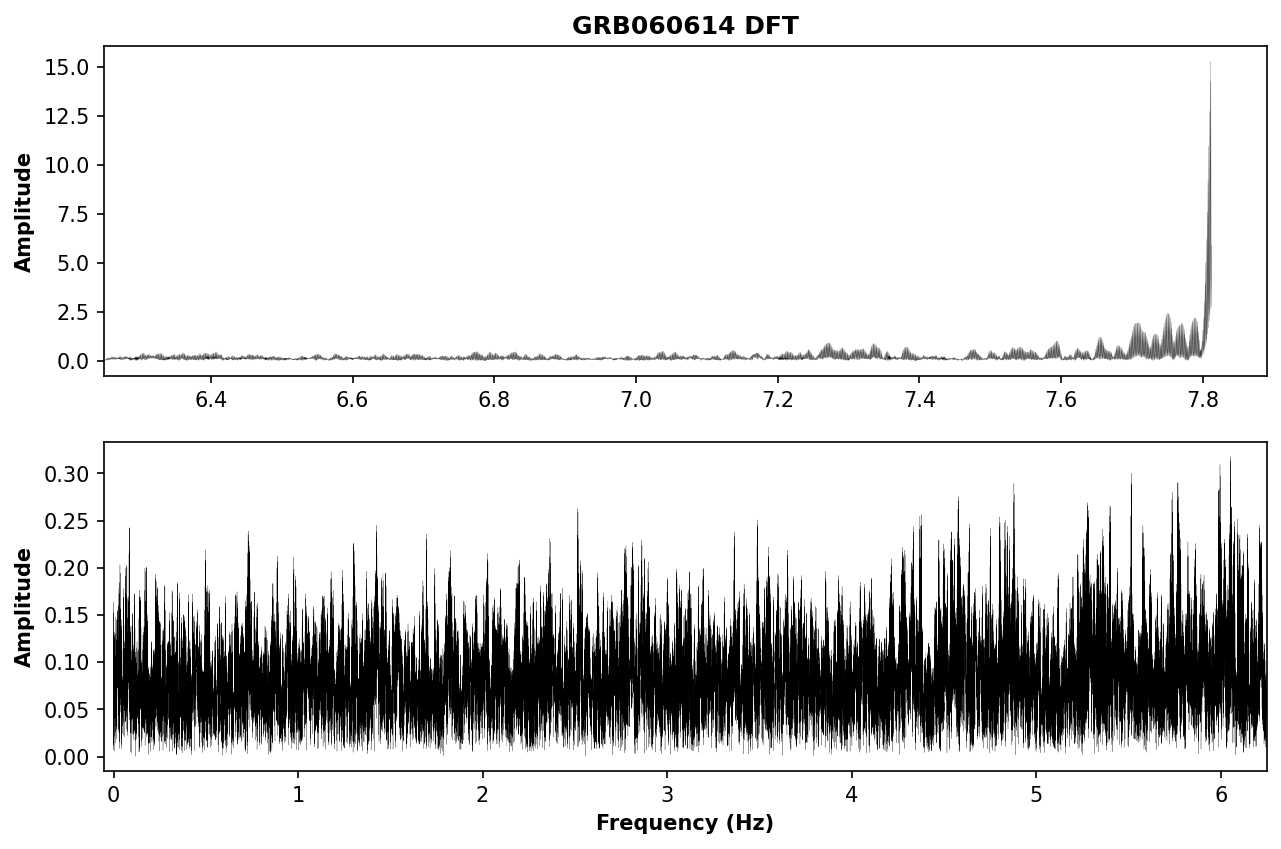

In [15]:
dft_random_GRB, dft_fig = object1.fourier_concatenate(zero_padded_data[random_index], plot=True, name=name)

Note that DFT data is below the Nyquist frequency, following the Nyquist-Shannon sampling theorem:

_The Nyquist-Shannon sampling theorem states that a signal sampled at a rate can be fully reconstructed if it contains only frequency components below half that sampling frequency. Thus the highest frequency output from the DFT is half the sampling rate._

With this, we can now calculate DFT for the entire zero-padded dataset using the `so_much_fourier` instance:

In [16]:
pre_processing_data = object1.so_much_fourier(zero_padded_data)

Performing DFT: 100%|██████████| 1318/1318 [00:53<00:00, 24.47GRB/s]


## Saving results

Finally, the pre-processing data stage is over. Then, we want to save all data in a compressed format to load in the next section. For this, you can use the `save_data` function (based in `savez_compressed` instance of Numpy):

In [17]:
object1.save_data(f"DFT_Preprocessed_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save Data with DFT
concatenated_data = object1.so_much_concatenate(zero_padded_data)  # Concatenate data without DFT
object1.save_data(f"non_DFT_Preprocessed_data_{object1.end}", names=GRB_names, data=concatenated_data)  # Save Data without DFT

Concatenating: 100%|██████████| 1318/1318 [00:43<00:00, 30.28GRB/s]
